# MiniLab: Logistic Regression and Support Vector Machines

Team Members:

- Name 1: Aniketh Vankina 
- Name 2: Indy Dhillon 
- Name 3: Jason Rupp
- Name 4: Suchismita Moharana

In [1]:
import datetime
import itertools
import os
import pathlib
import sklearn

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
## from: https://www2.1010data.com/documentationcenter/prod/Tutorials/MachineLearningExamples/CensusIncomeDataSet.html
header_names = [
    'age',
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'wage_per_hour',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'capital_gains',
    'capital_losses',
    'stock_dividends',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'instance_weight', ## this field is not used as a feature
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'num_emp',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'weeks_worked',
    'year',
    'income_50k',
]

In [3]:
data_dir = os.path.join(pathlib.Path(os.getcwd()).parent, 'data')
df = pd.read_csv(os.path.join(data_dir, 'census-income.data.csv'), header=None, names=header_names)
df_test = pd.read_csv(os.path.join(data_dir, 'census-income.test.csv'), header=None, names=header_names)
df = pd.concat([df,df_test]) ## the test file is also labelled so they can be merged
df = df.drop(columns=['instance_weight']) ## not used for our analysis

In [4]:
categorical_features = [
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'year',
]
df[categorical_features] = df[categorical_features].astype('category')

In [5]:
### Drop columns not used in modelling
df = df.drop(
    columns=[
        'state_prev_res',
        'country_father',
        'country_mother',
        'country_self',
    ]
)


From our previous EDA we saw that the columns 'state_prev_res', 'country_father', 'country_mother', and 'country_self' all have a large number of categories and most the rows had the same value (ie most people were from this country and didn't have a state of previous residence). These columns were dropped from our analysis so our models run in a reasonable time frame.

## Create Models

In [6]:
def get_model(classifier, numeric_features, categorical_features):
    ### Scale numerical, one hot categorical
    numeric_transformer = Pipeline(
        steps=[

            ('scaler', StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[

            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)]
    )
    model = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier),
        ]
    )
    
    return model

In [7]:
### Find the numerical/ categorical features
target = 'income_50k'
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object','bool', 'category']).drop([target], axis=1).columns

X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


Our classification task is to predict which people will have an income of over $50k, so we break that column out at this point. To avoid overfitting when training and tuning our models, we did an 80/20 train/test split where the models were trained with 80\% of the data and the remaining 20\% was strictly reserved for gauging the accuracy of the models trained using the training set. This helps assure us that the models aren't being tailored to the noise in a specific dataset and will generalize to unseen data.

In [8]:
import warnings
warnings.filterwarnings('ignore')

logreg_param_scores = {}


class_weights =  [None, 'balanced']
penalties = ['none','l1', 'l2',]
solvers = ['lbfgs', 'liblinear']

for cw in class_weights:
    for penalty in penalties:
        for solver in solvers:
            if solver == 'lbfgs' and penalty == 'l1': 
                continue
            if solver == 'liblinear' and penalty == 'none': 
                continue
            params = (cw, penalty, solver)


            classifier = LogisticRegression(class_weight=cw, penalty=penalty, solver=solver, n_jobs=-1, max_iter=100000,)
            model = get_model(classifier, numeric_features, categorical_features)
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_pred, y_test)
            logreg_param_scores[params] = acc


print('=' * 60)
for params, score in logreg_param_scores.items():
    print(params, score)

(None, 'none', 'lbfgs') 0.952754063852181
(None, 'l1', 'liblinear') 0.9528041833035401
(None, 'l2', 'lbfgs') 0.9527373573683947
(None, 'l2', 'liblinear') 0.952754063852181
('balanced', 'none', 'lbfgs') 0.8564745977914029
('balanced', 'l1', 'liblinear') 0.8562240005346075
('balanced', 'l2', 'lbfgs') 0.8564578913076165
('balanced', 'l2', 'liblinear') 0.8564578913076165


In [9]:
best_logistic_regression = LogisticRegression(class_weight=None, penalty='l1', solver='liblinear', max_iter=100000)
best_logistic_regression_model = get_model(best_logistic_regression, numeric_features, categorical_features)
best_logistic_regression_model.fit(X_train,y_train)
best_logistic_regression_coefs = best_logistic_regression_model.named_steps['classifier'].coef_

In [10]:
y_pred = best_logistic_regression_model.predict(X_test)

In [11]:
#Getting a classification report
from sklearn.metrics import classification_report

classified_log_report = classification_report(y_test, y_pred)
print(classified_log_report)


              precision    recall  f1-score   support

    - 50000.       0.96      0.99      0.98     56157
     50000+.       0.72      0.39      0.51      3700

    accuracy                           0.95     59857
   macro avg       0.84      0.69      0.74     59857
weighted avg       0.95      0.95      0.95     59857



Here we took the training data and fit a logistic regression model with different parameters to try to find the best model.

The logistic regression is a form of linear regression that allows us to classify binomial data. In logistic regression, the log of the odds that the response (income > \\$50k) is has an affirmative value equals a weighted sum of the explanatory features and an intercept term. Our goal is to find the optimal weights and intercept.

The parameters that we used to try to optimize the logistic regression classifier are the class weight, solver, and penalty. The class weight means the classifier will try to give equal weight to predicting income > $50k vs < \\$50k, we tried with and without balanced class weight. The solver parameter is the specific algorithm used to find the optimal coefficients (feature weights). We tried the default 'lbfgs' and 'liblinear' which is recommended in the documentation for high dimensional data. The last parameter we tried was the penalty, which refers to the regularization type. Regularization is a penalty term that downweight models with large coefficients in an attempt to control overfitting. We tried, L1, L2, and no regularization.

The default logistic regression parameters in sci-kit learn are the `lbfgs` solver, `l2` penalty, and no class weight balancing. The accuracy with these default parameters was 95.27\%. After trying different combinations of parameters, we found that the logistic regression with `l1` regularization, no class balancing, and a `liblinear` solver just barely outperformed the default parameters with an accuracy of 95.28\%. This was not a meaningful improvement and we see that only the class weight balancing had a big effect. 

It should be noted that 93.8\% of people had an income less than \\$50k, as seen in our EDA, so the model does perform better than guessing everyone has income less than \\$50k, which would have given an accuracy of 93.8\%). Using the class weight parameter might have improved the ability to detect those who have income over \\$50k, but since we are only interested in accuracy, class balancing is not a concern at the moment.

In [12]:
sgd_param_scores = {}


class_weights =  [None, 'balanced']
penalties = ['l1', 'l2']
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1]

for cw in class_weights:
    for penalty in penalties:
        for alpha in alphas:
            params = (cw, penalty, alpha)


            svm_sgd_classifier = SGDClassifier(class_weight=cw, penalty=penalty, alpha=alpha, max_iter=100000, n_jobs=-1, loss="hinge")
            svm_sgd_model = get_model(svm_sgd_classifier, numeric_features, categorical_features)
            svm_sgd_model.fit(X_train,y_train)
            svm_sgd_y_pred = svm_sgd_model.predict(X_test)

            svm_sgd_acc = accuracy_score(svm_sgd_y_pred, y_test)
            sgd_param_scores[params] = svm_sgd_acc


print('=' * 60)
for params, score in sgd_param_scores.items():
    print(params, score)

(None, 'l1', 1e-05) 0.9515177840519906
(None, 'l1', 0.0001) 0.9493626476435505
(None, 'l1', 0.001) 0.942796999515512
(None, 'l1', 0.01) 0.939572648144745
(None, 'l1', 0.1) 0.9381860099904773
(None, 'l2', 1e-05) 0.9513173062465543
(None, 'l2', 0.0001) 0.9509330571194681
(None, 'l2', 0.001) 0.9480094224568555
(None, 'l2', 0.01) 0.9428805319344438
(None, 'l2', 0.1) 0.9400237232069766
('balanced', 'l1', 1e-05) 0.8311809813388576
('balanced', 'l1', 0.0001) 0.8596321232270244
('balanced', 'l1', 0.001) 0.8421571411864944
('balanced', 'l1', 0.01) 0.789748901548691
('balanced', 'l1', 0.1) 0.6118081427401975
('balanced', 'l2', 1e-05) 0.820121289072289
('balanced', 'l2', 0.0001) 0.8672001603822443
('balanced', 'l2', 0.001) 0.8532836593882086
('balanced', 'l2', 0.01) 0.8317155888200211
('balanced', 'l2', 0.1) 0.7746796531733966


Next we wanted to try a Support Vector Machine model. SVMs draw hyperlanes that try to seperate data into areas where points will be labelled income > \\$50k vs areas where points will be labelled income > $50k. The model finds the minimum number of data points that are needed to create the boundary between these areas and labels these points the "support vectors". Our goal is to find the optimum support vectors.

Since our dataset was large and highly dimensional, we had trouble running the SVM on our full data so we ran Stochastic Gadient Descent to optimize the support vectors of the SVM using batches of our data at each upadte step instead of all the data.

The parameters that we used to try to optimize the logistic regression classifier are the class weight, penalty, and alpha. The class weight and penalty terms are equivalent to logistic regression above and we tried the same values. The alpha parameter is a weight that gets mulitpled to the regularization term making it more or less agressive. We tried values ranging from 0.00001 to .1, increasing by a factor af 10.

The default SGD parameters in sci-kit learn are an alpha of `0.0001`, `l2` penalty, and `no class` weight balancing. The accuracy with these default parameters was 95.17%. After trying different combinations of parameters, we did not find any other parameter combination that was better than default.

In [13]:
#Subsampling the dataset
sampleDF = df.sample(frac = .1)

if(0.1*(len(df)) == len(sampleDF)):
    print("good")
    print(len(df), len(sampleDF))


X = sampleDF.drop(target, axis=1)
y = sampleDF[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [14]:
from sklearn import svm

classifier = svm.SVC(max_iter=100000, gamma ='auto', C=0.0001, kernel='rbf')#,n_jobs=-1
model = get_model(classifier, numeric_features, categorical_features)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

acc_svm = accuracy_score(y_pred, y_test)

print(acc_svm)


0.938690277313732


Having built and tuned an SVM model using SGD, we then ran the full SVM model on only 10% of our data to improve computation time and observe the support vectors. We ran the SVM and were concerned to find that the accuracy was actually 93.8%, which is slightly worse than we would have expected from just guessing 'No' for every person. For SVM, the cost was derived from alpha from the best SGD classifier.

## Model Advantages

**Logistic Regression (LR) model**:
- Advantages
    - Simple model and works faster when we have linearly separable data.
    
- Disadvantages
    - Sensitive to outliers: More sensitive to outliers because the cost function diverges faster than those of SVM.
    
**Support Vector Machines (SVMs) model**:
- Advantages
    - Works on dataset that are not linearly separable.
    - Effective in high dimensional spaces.
    - Still effective in cases where number of dimensions is greater than the number of samples.
    - Not sensitive to outliers.
    
- Disadvantages
    - SVM is slower because of their compute and storage requirements increase rapidly with the number of training vectors.

## Interpret Feature Importance

In [15]:
## get catergorical cols after one hot
cat_columns = best_logistic_regression_model.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['onehot'].get_feature_names(categorical_features)
## combine numerical and categorical (same order as pipeline)
all_cols = np.concatenate((numeric_features, cat_columns), axis=0)
coef_scores = [coef_score for coef_score in zip(all_cols,best_logistic_regression_coefs[0])]
coef_scores.sort(key=lambda tup: abs(tup[1]), reverse=True)
for coef, weight in coef_scores:
    print('{coef:70}{weight:.3f}'.format(coef=coef, weight=weight))

education_ Doctorate degree(PhD EdD)                                  2.011
tax_filer_stat_ Nonfiler                                              -1.857
education_ Prof school degree (MD DDS DVM LLB JD)                     1.707
education_ Masters degree(MA MS MEng MEd MSW MBA)                     1.502
own_or_self_2                                                         -1.493
own_or_self_0                                                         -1.461
education_ Less than 1st grade                                        -1.413
education_ Children                                                   -1.290
det_ind_code_26                                                       1.268
det_hh_fam_stat_ Spouse of RP of unrelated subfamily                  1.237
det_occ_code_7                                                        1.145
det_occ_code_21                                                       1.107
sex_ Female                                                           -1.096
det_in

$$log(\frac{P}{1-P}) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 . . . . \beta_n X_n$$

The model will use the logit function, shown above, to calculate a probability for each observation it is trying to predict. For this model, if the value of prediction is greater than 0.5, or 50\%, it will be put into the greater than \\$50,000 category.

The table above the logit function show the coefficients from the logistic regression model that provided the highest accuracy. These weights relate the classification task in that the greater the magnitude weight value, the more probable one is to be classified as "above \\$50,000", and the converse is also true. 

One can also use the value of the weights to calculate an estimate of the probability of which class one will fall into, particularly with regard to some of the categorical variables. The categorical variables have been on-hot encoded, and therefore the value will assume either a 0 or 1. This makes calculating the odds relatively simple and easy to interpret. 

For instance, the feature above with the greatest weight is "education_ Doctorate degree(PhD EdD)". This has been encoded from the education feature, and if the observation had a doctorate degree, the value for this would assume the value of 1. we use this to calculate the odds of one earning more than \\$50,000, if they have earned this degree by raising the value of the weight to $e^{weight}$. So $e^{2.040} = 7.69$, means that if one earns one of these degrees they are over 7 times more likely to earn more than \\$50,000 annually during the time when this data was collected. 

On the same note, if we take the term with the most negative value of "tax_filer_stat_ Nonfiler" = -1.501 if we raise this to the power of $e^{-1.501}=0.223$. This indicates that if one is a nonfiler, there odds of earning more than \\$50,000 annual decrease by about 4 times.

With this, we can see above that some of the most important features that lead in essence to a salary greater than \\$50,000 are tied to education, which is what we all hope! The 3 highest contributing features are a doctorate, professional, or masters degree. These variables are likely quite important due to if one goes through all this secondary education, it would hopefully yield a reward of a salary which is greater than \\$50,000.

Some of the variables which have high coefficients in this model are somewhat difficult to interpret due to the nature of the data. The "det_ind_code" feature from this data set is a categorical one, which assigns a numerical variable to whichever industry the person, or observation is employed. There are quite a few of the top 20 feature weights that fall into this similar scenario.

There are however some features which are rather intuitive. It is certainly worth noting, and it is very unfortunate we can see from the weight list that there is a negative association with a person being female with making more than \\$50,000 annually when this survey is taken. The odds are $e^{-1.120} = 0.33$ or they are almost 3 times less likely to make less than \\$50,000. This could be due to a multitude of factors, but one certainly wouldn't hope to see this in the top 20.

Also from this weight table we can see that a great many of the feature weights were equal to zero or very close. This indicates that they have very little to no contribution to this model. Many of these features are variables which have been one hot encoded and are categories of other attributes that may contribute.


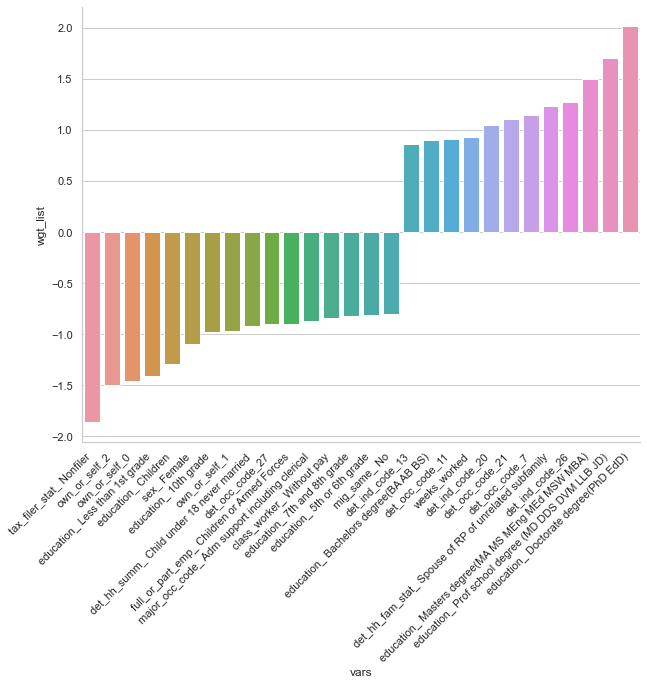

In [16]:
# Add sns plot
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weight_df=pd.DataFrame({"wgt_list":best_logistic_regression_coefs[0], "vars":all_cols})

sns.set(rc={'figure.figsize':(10, 8)})
# sns.set_context("paper", font_scale=0.9)
sns.set_style("whitegrid")

ax = sns.barplot(x= "vars", y="wgt_list", data= weight_df.loc[abs(weight_df['wgt_list']) > 0.8 ], order=weight_df.loc[abs(weight_df['wgt_list']) > 0.8].sort_values('wgt_list').vars)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.despine()

The above visualization depicts a sample of the coefficients from the most accurate logistic regression model. These are the features which had a coefficient above 0.8. 

## Interpret Support Vectors

Support Vector modeling proved especially more challenging than Logistic Regression models. As stated in previous sections, our dataset is large and has many features. We wanted to perform an SVM model on the entire dataset, including a majority of the features (the only features removed were categorical variables with multi levels and sub-categories). The features were removed based on feedback given from the lectures, as complex features such as the ones removed would complicate the model fit. Additionally, the data is multidimensional, so we used a RBF kernel. However, due to large number of training vectors, it took more compute power and time to finish. For that reason, we decided to subsample our dataset to include 10% of the data. This was done to cut compute time and there was no significant change in accuracy.

In [17]:
#Getting a classification report
from sklearn.metrics import classification_report
classified_report = classification_report(y_test, y_pred)
print(classified_report)

              precision    recall  f1-score   support

    - 50000.       0.94      1.00      0.97      5619
     50000+.       0.00      0.00      0.00       367

    accuracy                           0.94      5986
   macro avg       0.47      0.50      0.48      5986
weighted avg       0.88      0.94      0.91      5986



Due to the sheer number of observations and variables, there were roughly 3000 support vectors. This is mainly telling us that there are about 3000 vectors in which lie closes to the decision boundary. However, since we decided to use majority of features in our dataset we ended up with a good amount of support vectors due to multidimensionality. The number of support vectors should decrease when we limit the number of features we want to use in our model. To find the optimal cost, we used SGD. The below set of code gives us the number of vectors. The classification report table above also gives us an overall picture on how well the SVM model performed. The support column in the classification report represent the number of samples that lie in the class (income_50k).

In [18]:
#Look at support vectors
print(classifier.support_vectors_.shape)
print(classifier.support_.shape)
print(classifier.n_support_)
print(classifier.classes_)
print(classifier.support_)

(2960, 324)
(2960,)
[1480 1480]
[' - 50000.' ' 50000+.']
[   20    23    37 ... 23932 23933 23937]


At a closer examination of the breakdown of the ~3000 support vectors, we see that there are 1480 negative support vectors and 1480 positive support vectors (-50k and +50k respectively). The below graphs show the chosen support vectors for all the numeric values of our dataset. At first glance, the instances chosen from the support dataframe compared to sample dataframe seem very similar. This is not the case as there are modest differences between each instance.

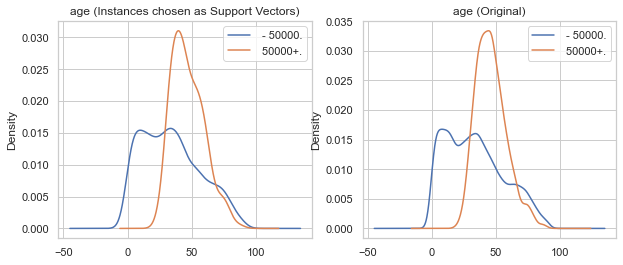

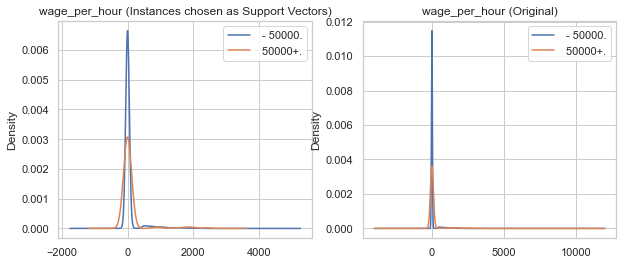

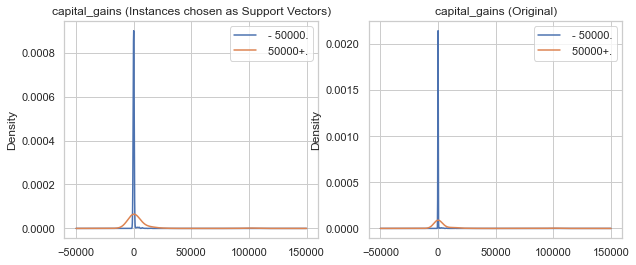

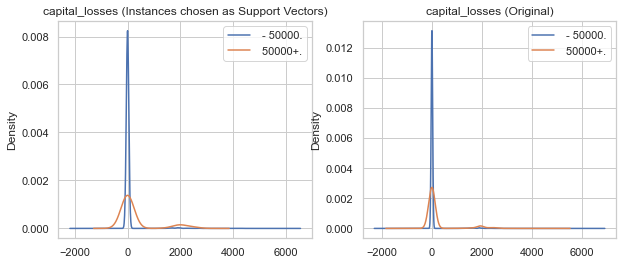

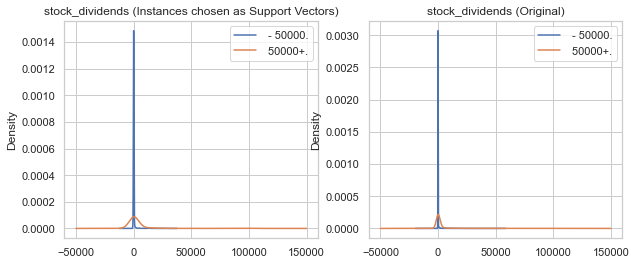

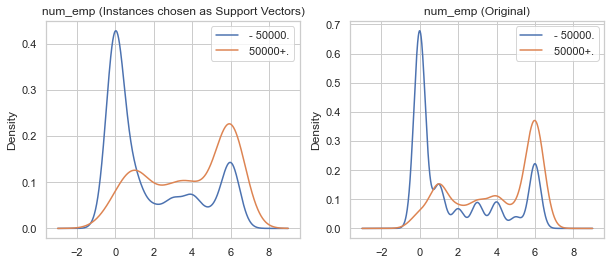

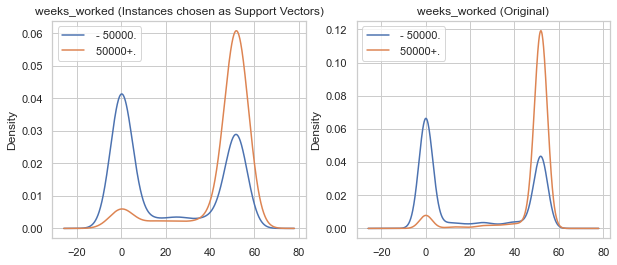

In [19]:
df_support = sampleDF.iloc[classifier.support_,:].copy()
vars_to_plot = numeric_features

df_grouped_support = df_support.groupby(['income_50k'])
df_grouped = sampleDF.groupby(['income_50k'])

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend([' - 50000.', ' 50000+.'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend([' - 50000.', ' 50000+.'])
    plt.title(v+' (Original)')


*Note: Since the data was subsampled, we might see one a wide difference between both classes (-50k, +50K).

For age, the instances are not along the decision boundary for above and below 50k. This tells us that the marginal boundaries is quite large for people aged from 20-50 make less than 50k. On the other hand, it looks there is a narrower population of people that make more than 50k, which shows clear separation. Comparing this to the sampled dataset shows there is not much difference other than sharp inclines and declines at specific ages.

Wage, capital gains, capital losses, and stock dividends shows us that the instances do not lie close to boundary as well. This can be due to the disparity between people under the poverty line and the middle class, which is the largest class of family in the US. It's also safe to assume that many of the folks making less than 50k are investing money for any capital returns. Thats why we see a straight line for people that make less than 50k. The only difference that is noticeable is for the few that make more than 50k that actually see returns and gains.

For the number of employee’s instance, we do see that at some points the instances are close to the decision boundary. Specifically, at 1-4 employees the instances are right along the boundary of separation. It makes sense that at 0, there is high volume of people making less than 50k. At zero, its easily separable. The curves are more pronounced in the original graph. At 6 employees, there are more people that make more than 50k and it is very rare that alot less people that make less than 50k with more than 6 employees.

The weeks worked graphs show similar trends we been seeing as for the first few features. Looks like at 0 hours its obvious that a majority of people make less than 50k because they are not working. There is only a few people that do not work that make more than 50k. Could be due to some external factors, such as lottery or gambling winnings. At 40 hours per week the instances are right along the decision boundary but separate past 40.

In [21]:
def categorical_explanitory_binary_response_chart(chart_df1, chart_df2, field, target, toggle=False):
    drop_index = 2
    if toggle:
        drop_index = 1
    fig, (axA, axB) = plt.subplots(1, 2)
    chart_dfs = [chart_df1,chart_df2]
    axs = [axA, axB]
    
    for i, chart_df in enumerate(chart_dfs):
        field_count  = chart_df[field].value_counts()
        field_count_df = field_count.to_frame()
        field_count_df.columns = ['count']

        field_target_pct = pd.crosstab(chart_df[field], chart_df[target], normalize='index') * 100
        field_target_pct = field_target_pct.reset_index()
        field_target_pct = field_target_pct.drop(field_target_pct.columns[-drop_index],axis=1)

        field_target_data = field_target_pct.merge(field_count_df, right_index=True, left_on=field).sort_values('count', ascending=False).reset_index(drop=True)
        print(field_target_data)

        sns.pointplot(x=field_target_data[field], y=field_target_data.iloc[:, -2], color='black', legend=False, ax=axs[i])
        axs[i].set_ylabel('% {t} (line)'.format(t = target))
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

       sex    50000+.  count
0   Female   2.749361   1564
1     Male  10.243553   1396
       sex   50000+.  count
0   Female   2.56787  15655
1     Male  10.12401  14273


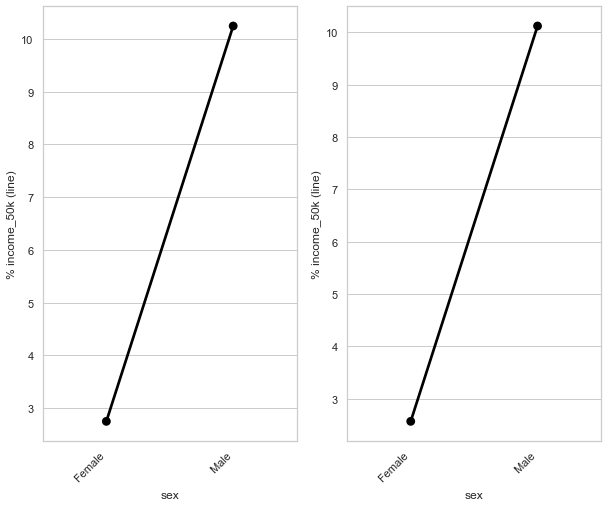

                                  education    50000+.  count
0                      High school graduate   3.491620    716
1                                  Children   0.000000    674
2                Some college but no degree   7.582938    422
3                Bachelors degree(BA AB BS)  20.766773    313
4                         7th and 8th grade   0.000000    114
5                                10th grade   0.892857    112
6                                 9th grade   0.943396    106
7                                11th grade   2.150538     93
8       Associates degree-occup /vocational  11.111111     90
9    Masters degree(MA MS MEng MEd MSW MBA)  30.681818     88
10       Associates degree-academic program   9.677419     62
11                         5th or 6th grade   0.000000     54
12                    12th grade no diploma   0.000000     36
13                 1st 2nd 3rd or 4th grade   4.166667     24
14   Prof school degree (MD DDS DVM LLB JD)  43.478261     23
15      

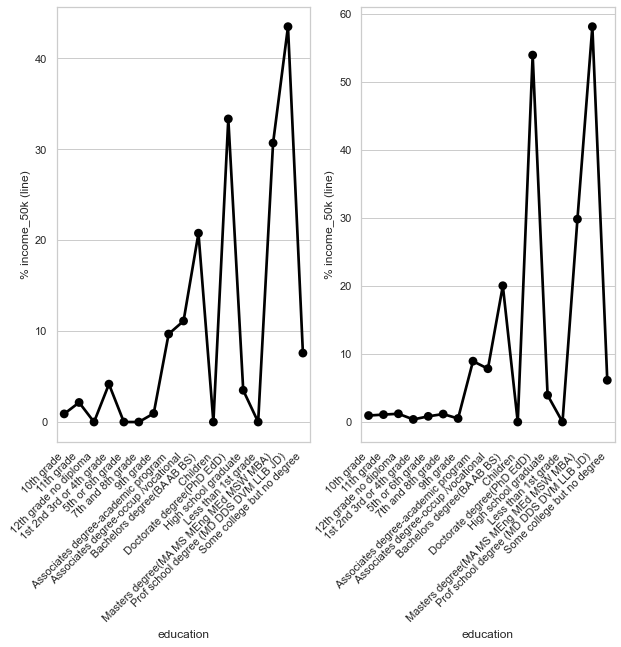

In [23]:
for col in ['sex', 'education']:
    categorical_explanitory_binary_response_chart(df_support, sampleDF, col, 'income_50k')

These graphs are similar to what was described in the support vectors graph above but they were exclusively for categorical variables. The only difference is that there is a peak for `1st 2nd 3rd or 4th grade` in support dataframe which could be because of low sample size. Overall, we see that in all the charts above the support vector boundaries are similar to the sample dataset. This means, SVM decision did not add much information.